In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.linalg
import time

In [45]:
def construct_D(m, r):
    D_tail = np.ones(m-r) * 4e-3
    D_main = r - np.arange(1, r+1) + 1
    return np.diag(np.concatenate((D_main, D_tail)))

def generate_A(m, n, r):
    X = scipy.linalg.orth(np.random.randn(m, m))
    Y = scipy.linalg.orth(np.random.randn(n, m))
    D = construct_D(m, r)
    return X @ D @ Y.T, X, Y, D

def randomized_svd(A, left_c, right_c):
    A_fro_sq = np.power(np.linalg.norm(A, ord='fro'), 2)
    p_i = np.power(np.linalg.norm(A, axis=0), 2) / A_fro_sq
    col_inds = np.where(np.random.multinomial(left_c, p_i) > 0)[0]
    A_prime_left = A[:, col_inds] / np.sqrt(left_c * p_i[np.newaxis, col_inds])
    U, Sigma_left, _ = np.linalg.svd(A_prime_left, full_matrices=False)
    
    p_j = np.power(np.linalg.norm(A, axis=1), 2) / A_fro_sq
    row_inds = np.where(np.random.multinomial(right_c, p_j) > 0)[0]
    A_prime_right = A[row_inds, :] / np.sqrt(right_c * p_j[row_inds, np.newaxis])
    _, Sigma_right, Vt = np.linalg.svd(A_prime_right, full_matrices=False)
    
    return U, Vt.T, Sigma_left, Sigma_right

def compute_error(U_hat, U_true):
    def multiply_and_compute_norm(U_hat, U_true, x):
      prod = U_hat @ (U_hat.T @ x) - U_true @ (U_true.T @ x)
      prod = U_hat @ (U_hat.T @ prod) - U_true @ (U_true.T @ prod)
      norm = x.T @ prod 
      prod /= np.linalg.norm(prod)
      return prod, norm
    
    vec = np.random.randn(U_hat.shape[0], 1)
    vec /= np.linalg.norm(vec)
    prev_vec = np.zeros(vec.shape)
    while np.linalg.norm(vec - prev_vec) > (1/np.sqrt(vec.size)):
      prev_vec = vec
      vec, norm = multiply_and_compute_norm(U_hat, U_true, vec)
    return vec, np.sqrt(norm)

def search_C(A, U_true, V_true, r, eps, step_size=5):
  c_U, c_V, Ueps, Veps = 100, 50, np.inf, np.inf
  Ur_true, Vr_true = U_true[:, :r], V_true[:, :r]
  while abs(Ueps - eps) >= eps * 0.5 or abs(Veps - eps) >= eps * 0.5:
    U, V, _, _ = randomized_svd(A, c_U, c_V)
    Ur_hat, Vr_hat = U[:, :r], V[:, :r]
    if abs(Ueps - eps) >= eps * 0.5:
      _, Ueps = compute_error(Ur_hat, Ur_true)
      if Ueps > eps:
        c_U += step_size
      elif eps - Ueps >= eps * 0.5:
        c_U -= step_size
      
    if abs(Veps - eps) >= eps * 0.5:
      _, Veps = compute_error(Vr_hat, Vr_true)
      if Veps > eps:
        c_V += step_size
      elif eps - Veps >= eps * 0.5:
        c_V -= step_size
  
  print(f'Final: ueps {Ueps}, veps {Veps}')
  return c_U, c_V

### Q2.i

In [3]:
## Constants
m = 1000
n = 100000
r = 10
num_experiments = 10
eps_list = [0.01, 0.05, 0.1]

In [4]:
A, X, Y, D = generate_A(m, n, r)
A_svd_start = time.time()
U_true, S_true, Vt_true = np.linalg.svd(A, full_matrices=False)
A_svd_end = time.time()
V_true = Vt_true.T

A_svd_runtime = A_svd_end - A_svd_start

In [5]:
### Pick c_U and c_V before doing the experiments
results = {}
Ur_true, Vr_true = U_true[: , :r], V_true[:, :r]
for eps in eps_list:
  this_res = {'true_params': {'r': r, 'A': A, 'U_true': U_true, 'V_true': V_true}}
  
  c_U, c_V = search_C(A, U_true, V_true, r, eps, step_size=5)
  print(f'For eps {eps}, U columns {c_U} and V columns {c_V}')
  this_res['c_U'], this_res['c_V'] = c_U, c_V
  
  run_time_list, U_err_list, V_err_list, approxA_params_list = [], [], [], []
  for i in range(num_experiments):
    random_svd_start = time.time()
    U, V, Sl, Sr = randomized_svd(A, c_U, c_V)
    random_svd_finish = time.time()
    
    U_err_list.append(compute_error(U[:, :r], Ur_true)[1])
    V_err_list.append(compute_error(V[:, :r], Vr_true)[1])
      
    approxA_params_list.append({'U': U, 'V': V, 'Sl': Sl, 'Sr': Sr})
    run_time_list.append(random_svd_finish - random_svd_start)

  this_res['ave_run_time'] = np.mean(run_time_list)
  this_res['ave_U_err'] = np.mean(U_err_list)
  this_res['ave_V_err'] = np.mean(V_err_list)
  this_res['approxA_params'] = approxA_params_list
  
  results[eps] = this_res

Final: ueps [[0.00803281]], veps [[0.01067121]]
For eps 0.01, U columns 15 and V columns 20
Final: ueps [[0.06499235]], veps [[0.05942262]]
For eps 0.05, U columns 15 and V columns 15
Final: ueps [[0.14896576]], veps [[0.0504955]]
For eps 0.1, U columns 15 and V columns 10


In [7]:
for eps in eps_list:
  print(f'eps: {eps}')
  print(f'cU = {results[eps]["c_U"]}, cV = {results[eps]["c_V"]}')
  print(f'ave_run_time = {results[eps]["ave_run_time"]}')
  print(f'ave_U_err = {results[eps]["ave_U_err"]}')
  print(f'ave_V_err = {results[eps]["ave_V_err"]}')

eps: 0.01
cU = 15, cV = 20
ave_run_time = 1.0694395303726196
ave_U_err = 0.0032631206268224867
ave_V_err = 0.0020448154775077033
eps: 0.05
cU = 15, cV = 15
ave_run_time = 0.983266544342041
ave_U_err = 0.005819866987480276
ave_V_err = 0.004223312782887184
eps: 0.1
cU = 15, cV = 10
ave_run_time = 0.9317464351654052
ave_U_err = 0.006343336105101158
ave_V_err = 0.14795552959402675


In [55]:
## Use the average over 10 experiments to pick c_U and c_V
results = {}
Ur_true, Vr_true = U_true[: , :r], V_true[:, :r]
for eps in eps_list:
  this_res = {'true_params': {'r': r, 'A': A, 'U_true': U_true, 'V_true': V_true}}
  U_eps = V_eps = np.inf
  c_U = c_V = 1
  freeze_U = freeze_V = False
  while U_eps > eps or V_eps > eps:
    run_time_list, U_err_list, V_err_list, approxA_params_list = [], [], [], []
    for i in range(num_experiments):
      random_svd_start = time.time()
      U, V, Sl, Sr = randomized_svd(A, c_U, c_V)
      random_svd_finish = time.time()

      U_err_list.append(compute_error(U[:, :r], Ur_true)[1])
      V_err_list.append(compute_error(V[:, :r], Vr_true)[1])

      approxA_params_list.append({'U': U, 'V': V, 'Sl': Sl, 'Sr': Sr})
      run_time_list.append(random_svd_finish - random_svd_start)
      
    if not freeze_U:
      U_eps = np.mean(U_err_list)
      if U_eps > eps:
        c_U += 1
      else:
        freeze_U = True
    
    if not freeze_V:
      V_eps = np.mean(V_err_list)
      if V_eps > eps:
        c_V += 1
      else:
        freeze_V = True
    
    print(f'For eps {eps}, U eps {U_eps} and V eps {V_eps}')

    if U_eps > eps or V_eps > eps: continue # retry
      
    this_res['ave_run_time'] = np.mean(run_time_list)
    this_res['ave_U_err'] = U_eps
    this_res['ave_V_err'] = V_eps
    this_res['c_U'], this_res['c_V'] = c_U, c_V
    print(f'For eps {eps}, U columns {c_U} and V columns {c_V}')

    results[eps] = this_res

For eps 0.05, U eps 0.9999999996469098 and V eps 0.9999999997730246
For eps 0.05, U eps 0.9999999970858309 and V eps 0.9999999984614314
For eps 0.05, U eps 0.9999999944941583 and V eps 0.9999999929015846
For eps 0.05, U eps 0.9999999765705377 and V eps 0.9999999818522991
For eps 0.05, U eps 0.9999999359408178 and V eps 0.9999997256651818
For eps 0.05, U eps 0.9999947829436945 and V eps 0.9999991652150744
For eps 0.05, U eps 0.9999909064711338 and V eps 0.9999995233928246
For eps 0.05, U eps 0.999993601391683 and V eps 0.9999995214598713
For eps 0.05, U eps 0.9998802839659489 and V eps 0.9999996285245395
For eps 0.05, U eps 0.33210828922753277 and V eps 0.3866886708949496
For eps 0.05, U eps 0.287432479551903 and V eps 0.13113406752295137
For eps 0.05, U eps 0.10415493833115204 and V eps 0.1422304350547308
For eps 0.05, U eps 0.07749308997787116 and V eps 0.10752483243012204
For eps 0.05, U eps 0.07277066333240341 and V eps 0.0785484152344401
For eps 0.05, U eps 0.07327381868999902 and 

In [61]:
# np.savez(os.path.join(os.getcwd(), '0.01_partial_res'), **this_res)

# np.save(os.path.join(os.getcwd(), 'parti_res'), results)

In [57]:
print(f'SVD on A run time {A_svd_runtime}')
for eps in eps_list:
  print(f'eps: {eps}')
  print(f'cU = {results[eps]["c_U"]}, cV = {results[eps]["c_V"]}')
  print(f'ave_run_time = {results[eps]["ave_run_time"]}')
  print(f'ave_U_err = {results[eps]["ave_U_err"]}')
  print(f'ave_V_err = {results[eps]["ave_V_err"]}')

SVD on A run time 25.880300045013428
eps: 0.01
cU = 139, cV = 139
ave_run_time = 3.1308629512786865
ave_U_err = 0.0129898029304929
ave_V_err = 0.013044034069920982
eps: 0.05
cU = 21, cV = 18
ave_run_time = 1.0630456447601317
ave_U_err = 0.0386258574680395
ave_V_err = 0.04667273450168424
eps: 0.1
cU = 13, cV = 13
ave_run_time = 1.0410278558731079
ave_U_err = 0.07197495471873319
ave_V_err = 0.08758100503507334


### Q2.ii

In [72]:
## Use the average over 10 experiments to pick c_U and c_V
results_r = {}
eps = 0.05
r_list = [2, 5, 15, 20]
for r in r_list:
  A, X, Y, D = generate_A(m, n, r)
  
  A_svd_start = time.time()
  U_true, S_true, Vt_true = np.linalg.svd(A, full_matrices=False)
  A_svd_end = time.time()
  A_svd_runtime = A_svd_end - A_svd_start
  V_true = Vt_true.T
  this_res = {'true_params': {'r': r, 'A': A, 'U_true': U_true, 'V_true': V_true, 'A_svd_runtime': A_svd_runtime}}

  Ur_true, Vr_true = U_true[: , :r], V_true[:, :r]
  U_eps = V_eps = np.inf
  c_U = c_V = 1
  freeze_U = freeze_V = False
  while U_eps > eps or V_eps > eps:
    run_time_list, U_err_list, V_err_list, approxA_params_list = [], [], [], []
    for i in range(num_experiments):
      random_svd_start = time.time()
      U, V, Sl, Sr = randomized_svd(A, c_U, c_V)
      random_svd_finish = time.time()

      U_err_list.append(compute_error(U[:, :r], Ur_true)[1])
      V_err_list.append(compute_error(V[:, :r], Vr_true)[1])

      approxA_params_list.append({'U': U, 'V': V, 'Sl': Sl, 'Sr': Sr})
      run_time_list.append(random_svd_finish - random_svd_start)
      
    if not freeze_U:
      U_eps = np.mean(U_err_list)
      if U_eps > eps:
        c_U += 1
      else:
        freeze_U = True
    
    if not freeze_V:
      V_eps = np.mean(V_err_list)
      if V_eps > eps:
        c_V += 1
      else:
        freeze_V = True
    
    print(f'For eps {eps}, U eps {U_eps} and V eps {V_eps}')

    if U_eps > eps or V_eps > eps: continue # retry
      
    this_res['approxA_params_list'] = approxA_params_list
    this_res['ave_run_time'] = np.mean(run_time_list)
    this_res['ave_U_err'] = U_eps
    this_res['ave_V_err'] = V_eps
    this_res['c_U'], this_res['c_V'] = c_U, c_V
    print(f'For r {r}, U columns {c_U} and V columns {c_V}')

    results_r[r] = this_res

For eps 0.05, U eps 0.9999890870173784 and V eps 0.9999997428362832
For eps 0.05, U eps 0.43154492802240413 and V eps 0.23329160609571944
For eps 0.05, U eps 0.11613744293608426 and V eps 0.11688319619443369
For eps 0.05, U eps 0.07551619564872306 and V eps 0.09272942782984292
For eps 0.05, U eps 0.11564868539740722 and V eps 0.06924186712996894
For eps 0.05, U eps 0.07008357977878374 and V eps 0.06216695524183942
For eps 0.05, U eps 0.07773943752671561 and V eps 0.060755403042751954
For eps 0.05, U eps 0.061390917497165944 and V eps 0.07162507888842787
For eps 0.05, U eps 0.06614493013850564 and V eps 0.06498709434148058
For eps 0.05, U eps 0.052396131135985825 and V eps 0.05586815174781403
For eps 0.05, U eps 0.05373435412167442 and V eps 0.06971592472076629
For eps 0.05, U eps 0.048446999515545465 and V eps 0.04828988577952612
For r 2, U columns 12 and V columns 12
For eps 0.05, U eps 0.9999999541804664 and V eps 0.9999999874964051
For eps 0.05, U eps 0.9999921824468843 and V eps 0.

In [74]:
# np.save(os.path.join(os.getcwd(), 'partii_res'), results_r)

In [73]:
for r in r_list:
  print(f'r: {r}')
  print(f'A SVD runtime: {results_r[r]["true_params"]["A_svd_runtime"]}')
  print(f'cU = {results_r[r]["c_U"]}, cV = {results_r[r]["c_V"]}')
  print(f'ave_run_time = {results_r[r]["ave_run_time"]}')
  print(f'ave_U_err = {results_r[r]["ave_U_err"]}')
  print(f'ave_V_err = {results_r[r]["ave_V_err"]}')

r: 2
A SVD runtime: 25.88326907157898
cU = 12, cV = 12
ave_run_time = 0.9168684720993042
ave_U_err = 0.048446999515545465
ave_V_err = 0.04828988577952612
r: 5
A SVD runtime: 25.617685079574585
cU = 16, cV = 14
ave_run_time = 0.9856972694396973
ave_U_err = 0.04417138251687694
ave_V_err = 0.04683296686110315
r: 15
A SVD runtime: 25.91960597038269
cU = 23, cV = 22
ave_run_time = 1.0581168174743651
ave_U_err = 0.04797772471353246
ave_V_err = 0.04694524068864847
r: 20
A SVD runtime: 26.05293893814087
cU = 29, cV = 28
ave_run_time = 1.1385344743728638
ave_U_err = 0.046462809732582336
ave_V_err = 0.04897803505049753


In [76]:
cU_list = [results_r[r]['c_U'] for r in r_list]
cV_list = [results_r[r]['c_V'] for r in r_list]

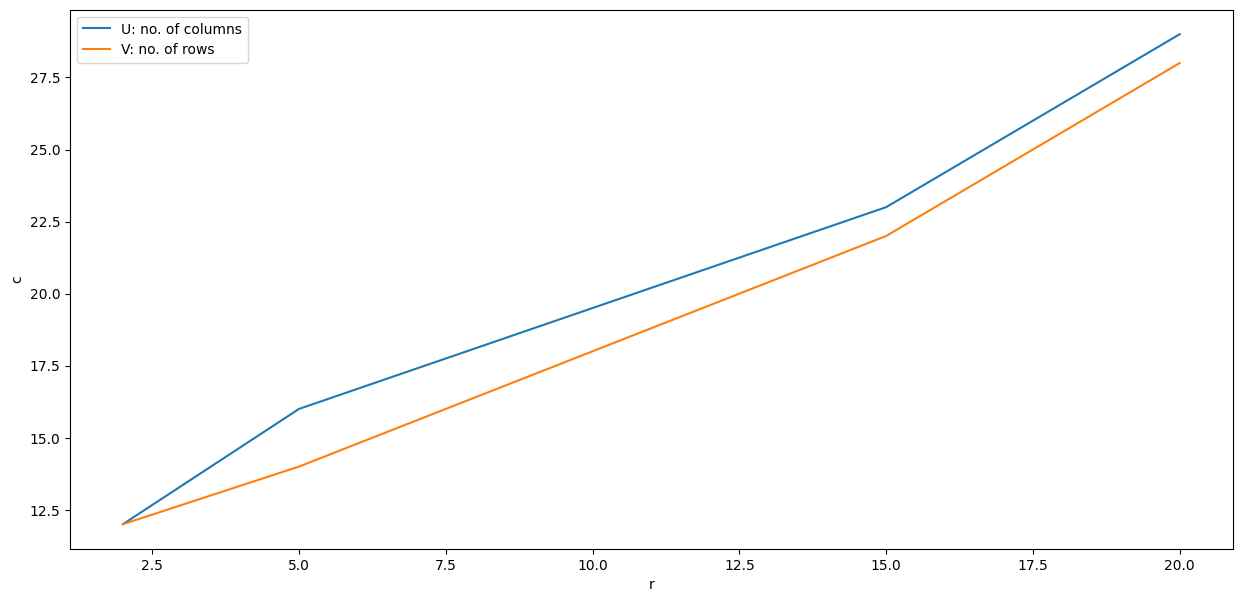

In [77]:
plt.figure(figsize=(15, 7))
plt.plot(r_list, cU_list, label='U: no. of columns')
plt.plot(r_list, cV_list, label='V: no. of rows')
plt.legend(); plt.xlabel('r'); plt.ylabel('c')
plt.show()